in this notebook we:
* stage 4a - NOT rescaled images, training from model on 384x512 images but now on 576x768

In [1]:
print(512 * 1.5)
print(384 * 1.5)

768.0
576.0


In [2]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb_no_rescale import *

In [3]:
%matplotlib inline

In [4]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/2sffnrk7

In [5]:
# PATH_TO_IMG = Path("/data")  # hence no rescale

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [6]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [7]:
len(df.uniqueName)

347120

In [8]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [9]:
# df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
# df.head()

In [11]:
%%time
data = get_training_data(df, (576, 768), batch_size=16)#, partial_pct=0.01)

CPU times: user 7.77 s, sys: 716 ms, total: 8.49 s
Wall time: 6.98 s


In [11]:
# %%time
# data.show_batch()

# Stage 4a

In [12]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage3a-intermediate_bestmodel");

In [13]:
learn.unfreeze()

In [14]:
%%time
run_find_lr(learn, "stage4a-5epochs-576_768-rescaled")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



CPU times: user 18.5 s, sys: 8.51 s, total: 27 s
Wall time: 1min 27s


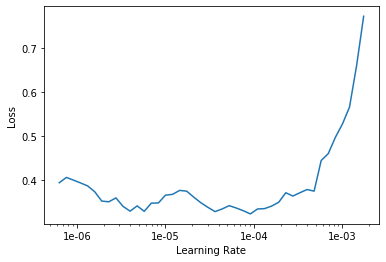

In [15]:
learn.recorder.plot()

In [16]:
initial_lr = 1e-3
lr = 1e-5 * 3
lr_end = initial_lr / 10
n_epochs =  5

In [ ]:
%%time
run_training(learn, "stage4a-5epochs-576_768-rescaled", lr=lr, lr_end=lr_end, n_epochs=n_epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.378959,1.035489,0.727239,7:31:35
1,0.360252,0.836888,0.765953,7:39:18
2,0.266131,0.735024,0.795475,7:55:58


Better model found at epoch 0 with valid_loss value: 1.0354893207550049.
Better model found at epoch 1 with valid_loss value: 0.8368878364562988.
Better model found at epoch 2 with valid_loss value: 0.7350241541862488.


**Warning!** The above training was interupted by me during epoch 5 (while only 3 are shown here, the 4th one was reported to wandb, accuracy 0.8049). I Jupyterlab broke and I was fooled that the training broke, while it actually went on underneath and I could have kept training. The model from epoch 4 is saved in _stage4a-intermediate_bestmodel.pth_

In [ ]:
learn.recorder.plot_losses()

In [ ]:
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig("loss_plot-stage4a-5epochs-576_768-rescaled.png")

### Load model and investigate results

In [12]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage4a-intermediate_bestmodel");

In [13]:
# wandb.init(project="gabon")

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

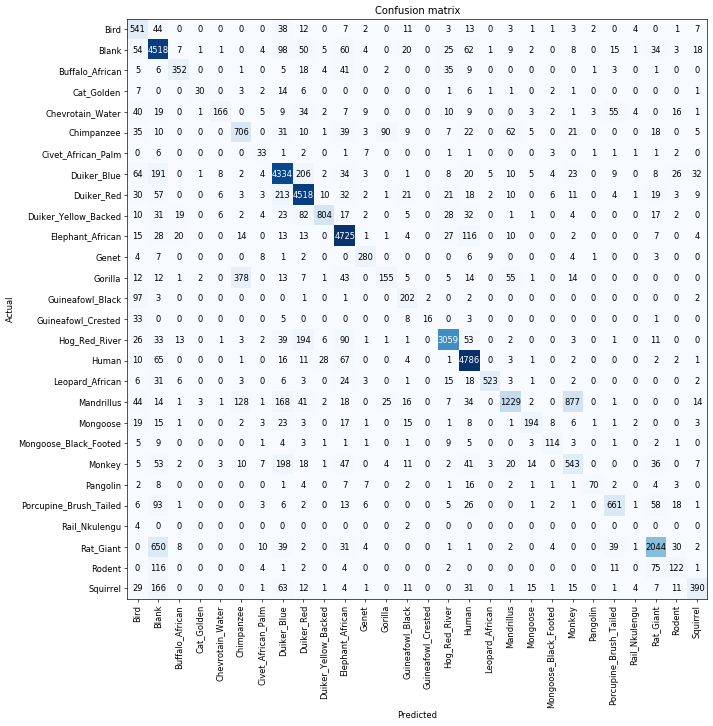

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
conf_m = interp.confusion_matrix()
np.save("conf_m-stage4a-5epochs-576_768-rescaled.npy", conf_m)

In [17]:
len(conf_m)

28

In [18]:
correct_p = sum([conf_m[i,i] for i in range(len(conf_m))])
correct_p

35115

In [19]:
all_p = conf_m.sum().sum()
all_p

43628

In [20]:
print(f"accuracy is: {round(100 * correct_p / all_p,2)}%")

accuracy is: 80.49%


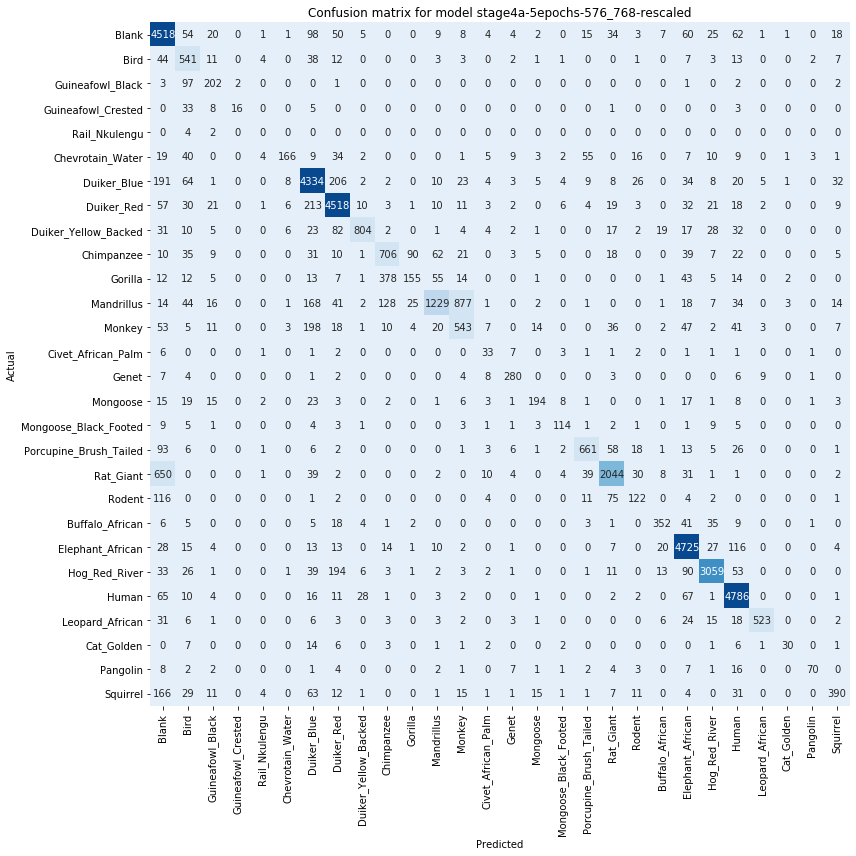

In [21]:
new_order = np.load("new_order.npy")
plot_conf_matrix_reordered(conf_m, 
                           sorted(classes),
                           new_order,
                           save_as = "conf_m-new_order-stage4a-5epochs-576_768-rescaled.png",
                           for_model = "stage4a-5epochs-576_768-rescaled")

In [22]:
preds = learn.get_preds(with_loss=True)
torch.save(preds, "preds-stage4a-5epochs-576_768-rescaled.pt")
preds

[tensor([[3.5703e-05, 1.4453e-03, 2.1806e-04,  ..., 3.0780e-04, 8.8320e-05,
          1.8646e-05],
         [3.3592e-06, 8.9282e-04, 2.0897e-05,  ..., 2.0979e-04, 1.8496e-04,
          2.6226e-05],
         [1.1736e-07, 9.9835e-01, 8.8253e-07,  ..., 1.1068e-07, 7.9199e-07,
          2.6767e-08],
         ...,
         [1.5777e-03, 5.9321e-03, 2.3185e-03,  ..., 5.4730e-02, 1.5423e-03,
          4.9275e-03],
         [1.2152e-03, 2.1015e-03, 6.7180e-04,  ..., 8.6167e-04, 1.8291e-04,
          3.1244e-01],
         [5.8496e-05, 5.2062e-03, 9.7686e-05,  ..., 1.7533e-05, 2.2499e-04,
          1.2575e-03]]),
 tensor([16, 23,  1,  ...,  9, 27, 18]),
 tensor([0.0055, 0.0016, 0.0016,  ..., 0.8937, 1.1633, 0.1306])]

In [23]:
images_list = data.valid_ds.items
np.save("images_list-stage4a-5epochs-576_768-rescaled.pt", images_list)

In [24]:
images_list

array(['/data/Gabon_trainingData/1039759.jpg', '/data/Gabon_trainingData/1195784.jpg',
       '/data/Gabon_trainingData/0880576.jpg', '/data/Gabon_trainingData/1194852.jpg', ...,
       '/data/Gabon_trainingData/1186961.jpg', '/data/Gabon_trainingData/1203146.jpg',
       '/data/Gabon_trainingData/1227618.jpg', '/data/Gabon_trainingData/1229185.jpg'], dtype='<U37')

### Export model

In [25]:
save_model(learn, "stage4a-intermediate_bestmodel")